<h1> Modification de la classe Runner.py pour renvoyer les éléments intérressants </h1>
Changement de loop et step dans le return afin de renvoyer les éléments intérressants.

In [ ]:
from pypownet.environment import RunEnv
from pypownet.agent import Agent
import logging
import logging.handlers
import threading
import queue

LOG_FILENAME = 'runner.log'


class TimestepTimeout(Exception):
    pass


class RunnerPerso(object):
    def __init__(self, environment, agent, render=False, verbose=False, vverbose=False, log_filepath='runner.log'):
        # Sanity checks: both environment and agent should inherit resp. RunEnv and Agent
        assert isinstance(environment, RunEnv)
        assert isinstance(agent, Agent)

        # Loggger part
        self.logger = logging.getLogger('pypownet')

        # Always create a log file for runners
        fh = logging.FileHandler(filename=log_filepath, mode='w+')
        fh.setLevel(logging.DEBUG)
        fh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
        self.logger.addHandler(fh)

        if verbose or vverbose:
            # create console handler, set level to debug, create formatter
            ch = logging.StreamHandler()
            ch.setLevel(logging.DEBUG if vverbose and verbose else logging.INFO)
            ch.setFormatter(logging.Formatter('%(levelname)s        %(message)s'))
            self.ch = ch
            # add ch to logger
            self.logger.addHandler(ch)
            self.logger.setLevel(logging.DEBUG if vverbose else logging.INFO)

        self.environment = environment
        self.agent = agent
        self.verbose = verbose
        self.render = render

        # First observation given by the environment
        self.last_observation = self.environment._get_obs()

        self.max_seconds_per_timestep = self.environment.game.get_max_seconds_per_timestep()

        if self.render:
            self.environment.render()

    def step(self):
        # Policy inference
        # def agent_inference(obs, q):
        #     action = self.agent.act(obs)
        #     q.put(action)
        # q = queue.Queue()
        # t = threading.Thread(target=agent_inference, name='AgentActThread', args=(self.last_observation, q))
        # t.start()
        # t.join(self.max_seconds_per_timestep)
        # if t.is_alive():
        #     self.logger.warn('\b\b\bTook too much time to compute action for current timestep: allowed at most %s '
        #                      'seconds; emulating do-nothing action' % str(self.max_seconds_per_timestep))
        #     action = self.environment.action_space.get_do_nothing_action()
        # else:
        #     action = q.get()

        action = self.agent.act(self.last_observation)

        # Update the environment with the chosen action
        observation, reward_aslist, done, info = self.environment.step(action, do_sum=False)
        if done:
            self.logger.warn('\b\b\bGAME OVER! Resetting grid... (hint: %s)' % info.text)
            observation = self.environment.reset()
        elif info:
            self.logger.warn(info.text)

        reward = sum(reward_aslist)

        if self.render:
            self.environment.render()

        self.last_observation = observation

        self.agent.feed_reward(action, observation, reward_aslist)

        self.logger.debug('action: %s' % ('[%s]' % ' '.join(list(map(lambda x: str(int(x)), action.as_array())))))
        self.logger.debug('reward: {}'.format('[' + ','.join(list(map(str, reward_aslist))) + ']'))
        self.logger.debug('done: {}'.format(done))
        self.logger.debug('info: {}'.format(info if not info else info.text))
        self.logger.debug('observation: \n%s' % observation.__str__())
        
        #print(self.environment.game.get_number_elements())

        return observation, action, reward

    #Dans cette fonction on va rajouter au retour tous les elements que l on souhaite afficher
    def loop(self, iterations):
        cumul_rew = 0.0
        rewListCumul = []
        rewList = []
        obsList = []
        actList = []
        for i in range(1, iterations + 1):
            if (i%100==0):
                print(i)
            (obs, act, rew) = self.step()
            cumul_rew += rew
            rewList.append(rew)
            rewListCumul.append(cumul_rew)
            obsList.append(obs)
            actList.append(act)
            self.logger.info("step %d/%d - reward: %.2f; cumulative reward: %.2f" % (i, iterations, rew, cumul_rew))
            #print(obs.planned_voltage_productions, '||', obs.planned_reactive_loads , '||', obs.ampere_flows)
            #print(obs.ampere_flows, '\n', obs.thermal_limits)
            
        # Close pygame if renderer has been used
        if self.render:
            self.environment.render()

        return cumul_rew, rewList, rewListCumul, obsList, actList 

On change la signature(_init_) <br> afin de pouvoir agir sur l'hyper paramètre epsilon 

In [3]:
from example_submission import baseline_agents
from example_submission import my_agents as ma

ModuleNotFoundError: No module named 'pypownet.agent'

<h2> Redéfinition de GreedySearch pour modifier epsilon

In [2]:
import pypownet.agent
import pypownet.environment
import example_submission.preprocessing
import numpy as np
import os
import itertools
import functools
import csv
import random



class GreedySearch(pypownet.agent.Agent):
    """ This agent is a tree-search model of depth 1, that is constrained to modifiying at most 1 substation
    configuration or at most 1 line status. This controler used the simulate method of the environment, by testing
    every 1-line status switch action, every new configuration for substations with at least 4 elements, as well as
    the do-nothing action. Then, it will seek for the best reward and return the associated action, expecting
    the maximum reward for the action pool it can reach.
    Note that the simulate method is only an approximation of the step method of the environment, and in three ways:
    * simulate uses the DC mode, while step is in AC
    * simulate uses only the predictions given to the player to simulate the next timestep injections
    * simulate can not compute the hazards that are supposed to come at the next timestep
    """

    def __init__(self, environment, epsi):
        super().__init__(environment)
        self.verbose = False
        self.epsilon = epsi
        self.ioman = ma.ActIOnManager(destination_path='saved_actions.csv')
        self.ioman2 = ma.ActIOnManager(destination_path='saved_states.csv')
        self.ioman3  = ma.ActIOnManager(destination_path='saved_rewards.csv')
        random.seed()

    def actGS(self, observation):
        import itertools

         # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        number_lines = action_space.lines_status_subaction_length
        # Will store reward, actions, and action name, then eventually pick the maximum reward and retrieve the
        # associated values
        rewards, actions, names = [], [], []

        # Test doing nothing
        if self.verbose:
            print(' Simulation with no action', end='')
        action = action_space.get_do_nothing_action()
        reward_aslist = self.environment.simulate(action, do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
        rewards.append(reward)
        actions.append(action)
        names.append('no action')

        # Test every line opening
        for l in range(number_lines):
            if self.verbose:
                print(' Simulation with switching status of line %d' % l, end='')
            action = action_space.get_do_nothing_action()
            action_space.set_lines_status_switch_from_id(action=action, line_id=l, new_switch_value=1)
            reward_aslist = self.environment.simulate(action, do_sum=False)
            reward = sum(reward_aslist)
            if self.verbose:
                print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
            rewards.append(reward)
            actions.append(action)
            names.append('switching status of line %d' % l)

        # For every substation with at least 4 elements, try every possible configuration for the switches
        for substation_id in action_space.substations_ids:
            substation_n_elements = action_space.get_number_elements_of_substation(substation_id)
            if 6 > substation_n_elements > 3:
                # Look through all configurations of n_elements binary vector with first value fixed to 0
                for configuration in list(itertools.product([0, 1], repeat=substation_n_elements - 1)):
                    new_configuration = [0] + list(configuration)
                    if self.verbose:
                        print(' Simulation with change in topo of sub. %d with switches %s' % (
                            substation_id, repr(new_configuration)), end='')
                    # Construct action
                    action = action_space.get_do_nothing_action()
                    action_space.set_switches_configuration_of_substation(action=action,
                                                                          substation_id=substation_id,
                                                                          new_configuration=new_configuration)
                    reward_aslist = self.environment.simulate(action, do_sum=False)
                    reward = sum(reward_aslist)
                    if self.verbose:
                        print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
                    rewards.append(reward)
                    actions.append(action)
                    names.append('change in topo of sub. %d with switches %s' % (substation_id,
                                                                                 repr(new_configuration)))

        # Take the best reward, and retrieve the corresponding action
        best_reward = max(rewards)
        best_index = rewards.index(best_reward)
        best_action = actions[best_index]
        best_action_name = names[best_index]

        # Dump best action into stored actions file
        self.ioman.dump(best_action)
        self.ioman3.dumpReward(best_reward)
        self.ioman2.dumpState(observation.as_array())

        if self.verbose:
            print('Action chosen: ', best_action_name, '; expected reward %.4f' % best_reward)

        return best_action

    def actRNS(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        action = action_space.get_do_nothing_action()

        # Select a random substation ID on which to perform node-splitting
        target_substation_id = np.random.choice(action_space.substations_ids)
        expected_target_configuration_size = action_space.get_number_elements_of_substation(target_substation_id)
        # Choses a new switch configuration (binary array)
        target_configuration = np.random.choice([0, 1], size=(expected_target_configuration_size,))

        action_space.set_switches_configuration_of_substation(action=action,
                                                              substation_id=target_substation_id,
                                                              new_configuration=target_configuration)

        # Ensure changes have been done on action
        current_configuration, _ = action_space.get_switches_configuration_of_substation(action, target_substation_id)
        assert np.all(current_configuration == target_configuration)

        # Dump best action into stored actions file
         #self.ioman.dump(action)

        return action

    def act(self, observation):
        x = random.random()
        if x<= self.epsilon:
            return self.actRNS(observation)
        else:
            return self.actGS(observation)

ModuleNotFoundError: No module named 'pypownet.agent'

<h2> Agents supplémentaires d'imitation avec des classifieurs différents

In [ ]:
from sklearn.svm import SVC

class ImitationAgentSVC(pypownet.agent.Agent):

    def __init__(self, environment):
        random.seed()
        super().__init__(environment)
        prepro = example_submission.preprocessing.Preprocessing("saved_actions.csv","saved_states.csv","saved_rewards.csv")
        self.data = prepro.main()
        X = self.data[0]
        y = self.data[1]
        y_label = []
        for i in range(len(y)):
            y_label.append(self.compute_action_key(y[i]))
        self.agent = SVC().fit(X, y_label)

    def compute_action_key(self, array):
        key =""
        for i in range(len(array)):
            key = key + str(array[i])
        return key

    def decode_from_key(self, key):
        action = np.zeros(len(key[0]))
        for i in range(len(key[0])):
            if key[0][i] == "1":
                action[i] = 1
        return action

    def act(self, observation):
        state = observation.as_array()
        id_action = self.agent.predict([state])
        action_space = self.environment.action_space
        return action_space.array_to_action(self.decode_from_key(id_action))

In [ ]:
from sklearn.naive_bayes import GaussianNB

class ImitationAgentGauss(pypownet.agent.Agent):

    def __init__(self, environment):
        random.seed()
        super().__init__(environment)
        prepro = example_submission.preprocessing.Preprocessing("saved_actions.csv","saved_states.csv","saved_rewards.csv")
        self.data = prepro.main()
        X = self.data[0]
        y = self.data[1]
        y_label = []
        for i in range(len(y)):
            y_label.append(self.compute_action_key(y[i]))
        self.agent = GaussianNB().fit(X, y_label)

    def compute_action_key(self, array):
        key =""
        for i in range(len(array)):
            key = key + str(array[i])
        return key

    def decode_from_key(self, key):
        action = np.zeros(len(key[0]))
        for i in range(len(key[0])):
            if key[0][i] == "1":
                action[i] = 1
        return action

    def act(self, observation):
        state = observation.as_array()
        id_action = self.agent.predict([state])
        action_space = self.environment.action_space
        return action_space.array_to_action(self.decode_from_key(id_action))

<h1> On prépare l'environnement pour notre agent </h1>

In [ ]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
get_ipython().run_line_magic('matplotlib', 'inline')
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
import seaborn as sns; sns.set()
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)



In [ ]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
get_ipython().system('ls $data_dir*')

In [ ]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='fixed', start_id=0,
                                              game_over_mode="soft")

In [ ]:
all_chronics = 8065 #Can set lower or higher but will bug on the association raw data & agent
x = np.arange(0,all_chronics)
NUMBER_ITERATIONS = all_chronics

In [ ]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

In [ ]:
import time

<h1> On va lancer les différents agents et récupèrer les éléments intérressant à afficher</h1>

<h2> On lance l'agent DoNothing </h2> (temps estimé : quelques secondes)

In [ ]:
import logging
import sys
import os
#NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ma.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListDN, rewListCumulDN,obsDN, actionDN = phase_runner.loop(iterations=NUMBER_ITERATIONS)

<h2> On lance l'agent Determinist</h2> (temps estimé : quelques secondes)

In [2]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ma.DeterministSubmission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListDS, rewListCumulDS, obsDS, actionDS = phase_runner.loop(iterations=NUMBER_ITERATIONS)

NameError: name 'os' is not defined

<h2> On lance l'agent GreedySubmission </h2> (temps estimé : 20 minutes)

In [5]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ma.GreedySubmission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListGDS, rewListCumulGDS, obsGDS, actionGDS = phase_runner.loop(iterations=NUMBER_ITERATIONS)


NameError: name 'os' is not defined

<h2> On lance l'agent de QLearning </h2> (temps estimé : 2-3 minutes)

In [ ]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.QLearningAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListQL, rewListCumulQL, obsQL, actionQL = phase_runner.loop(iterations=NUMBER_ITERATIONS)

<h2> On lance l'agent d'Imitation </h2>

In [ ]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.ImitationAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListI, rewListCumulI, obsI,actI = phase_runner.loop(iterations=NUMBER_ITERATIONS)

<h2> On lance des GreedySearch avec epsilon variant pour comparer leurs performances

In [ ]:
import logging
import sys
import os
#NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = GreedySearch(environment, 0.4)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)

# Run the planned experiment of this phase with the submitted model
score, rewListGSE04, rewListCumulGSE04,obsGSE04, actionGSE04 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

In [ ]:
import logging
import sys
import os
#NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = GreedySearch(environment, 0.2)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)

# Run the planned experiment of this phase with the submitted model
score, rewListGSE02, rewListCumulGSE02,obsGSE02, actionGSE02 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

In [ ]:
import logging
import sys
import os
#NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = GreedySearch(environment, 0.1)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)

# Run the planned experiment of this phase with the submitted model
score, rewListGSE01, rewListCumulGSE01,obsGSE01, actionGSE01 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

<h2> On lance nos agents d'imitation supplémentaires pour comparer leurs performances

In [ ]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ImitationAgentSVC(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListISVC, rewListCumulISVC, obsISVC,actI = phase_runner.loop(iterations=NUMBER_ITERATIONS)

In [ ]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ImitationAgentGauss(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListI, rewListCumulI, obsI,actI = phase_runner.loop(iterations=NUMBER_ITERATIONS)

<h1> Création de tous les graphiques </h1>

<h2> Comparasion des différents agents selon le reward by iterations ou le reward cumulé </h2>

NameError: name 'x' is not defined

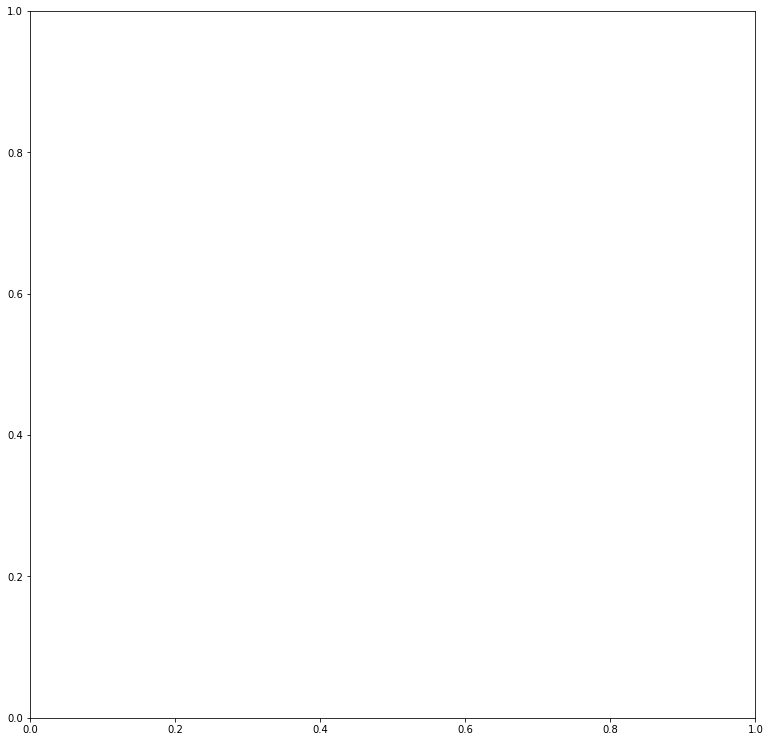

In [15]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
ax.plot(x,rewListCumulDN, label = "DoNothing", Color = 'r')
ax.plot(x,rewListCumulI, label = "Imitation", Color = 'b')
ax.plot(x,rewListCumulDS, label = "Determinist", Color = 'y')
ax.plot(x,rewListCumulQL, label = "QLearning", Color = 'p')
ax.plot(x,rewListCumulGS, label = "GreedySubmission", Color = 'g')
ax.set_title("Comparaison DoNothing - Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

<h2> Affichage de des résultats de GreedySearch en fonction de ses hyper Paramètres </h2>

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (25,16))
ax.plot(x,rewListCumulGSE01, label = "Epsilon = 0.1", Color = 'r')
ax.plot(x,rewListCumulGSE02, label = "Epsilon = 0.2", Color = 'y')
ax.plot(x,rewListCumulGSE04, label = "Epsilon = 0.4", Color = 'm')
ax.set_title("Comparaison GreedySearch en fonction des HyperParamètres", fontsize =30)
ax.set_xlabel('Iteration n°',fontsize =30)
ax.set_ylabel('Reward Cumulé',fontsize =30)
ax.legend(fontsize =30, loc = 3)

<h2> Résultats d'Imitation en fonction des méthodes de classification

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (25,16))
ax.plot(x,rewListCumulI, label = "MLPClassifier", Color = 'r')
ax.plot(x,rewListCumulISVC, label = "SVC", Color = 'g')
ax.plot(x,rewListCumulINB, label = "GaussianNB", Color = 'b')
ax.set_title("Comparaison d'Imitation Agent selon le classifieur", fontsize =30)
ax.set_xlabel('Iteration n°',fontsize =30)
ax.set_ylabel('Reward Cumulé',fontsize =30)
ax.legend(fontsize =30, loc = 3)

<h2> Affichage simple des Reward pour un unique agent </h2> (Ajouter les initiales de l'agent)

In [ ]:
#GreedySearch : GSE0#epsilon_decimal_value#
#DoNothing : DN
#DeterministSubmission : DS
#GreedySubmission : GDS
#QLearning : QL
#Imitation : I

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(x,rewList#REPLACEHERE#)
ax.set_title('DoNothing rewards by iteration')
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

<h3> Méthode pour réduire les valeurs extrème (Game Over) des rewards </h3>

In [1]:
cpt = 0
for i in rewList#REPLACEHERE# :
    if i ==-2:
        rewList[cpt] =-2
    cpt+=1

NameError: name 'rewListX' is not defined

<h2> Préparation des données Raw pour l'affichage </h2>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*
loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')

total_prod =[0]*8065
for i in df_loads_p['0']:
    total_prod+=df_loads_p['0'][i]
total_consuption = [0]*8065
for i in df_prods_p['0']:
    total_consuption += df_prods_p['0'][i]
hazards = [0]*8065
for i in df_hazards['0']:
    hazards += df_hazards['0'][i]
maintenance = [0]*8065
for i in df_maintenance['0']:
    maintenance += df_maintenance['0'][i]

<h2> Affichage des données Raw </h2>
<h3> Affichage des productions </h3>

In [ ]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

<h3> Comparaison consommation/Production </h3>

In [ ]:
x = np.arange(1,8066)
fig, ax = plt.subplots(1,1,figsize = (20,13))
ax.plot(x,total_consuption, label = "Consuption", Color = 'r')
ax.plot(x,total_prod, label = "Prod", Color = 'g')
ax.set_title("Consuption VS Production")
ax.set_xlabel('Time')
ax.set_ylabel('Power (MW)')
ax.legend()

<h3> Mise en superposition du reward de l'agent avec la consommation et les hazards </h3>

In [ ]:
fig, ax = plt.subplots(3,1,figsize = (20,18))
coefDiv = 1
decalage = 0
ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewListDN[decalage:int(len(rewListDN)/coefDiv)+decalage], label = "DoNothing", Color = 'r')
ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewListGSE01[decalage:int(len(rewListGSE01)/coefDiv)+decalage], label = "GreedySearch Epsi = 0.1", Color = 'b')
ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewListI[decalage:int(len(rewListI)/coefDiv)+decalage], label = "Imitation", Color = 'g')
ax[0].set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax[0].set_xlabel('Iteration n°')
ax[0].set_ylabel('Reward')
ax[0].legend()
ax[1].plot(x[decalage:int(len(x)/coefDiv)+decalage],total_consuption[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Consuption", Color = 'r')
ax[1].plot(x[decalage:int(len(x)/coefDiv)+decalage],total_prod[decalage:int(len(total_prod)/coefDiv)+decalage], label = "Prod", Color = 'g')
ax[1].set_title("Consuption VS Production")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Power (MW)')
ax[1].legend()
ax[2].plot(x[decalage:int(len(x)/coefDiv)+decalage],hazards[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Hazards", Color = 'y')
ax[2].plot(x[decalage:int(len(x)/coefDiv)+decalage],hazards[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Maintenace", Color = 'b')
ax[2].set_title("Consuption VS Production")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Power (MW)')
ax[2].legend()

<h2>Préparation des données thermique <br> et de la charge des substations en fonction de l'agent X</h2>
(changer obsX avec le nom de l'agent souhaité)

In [ ]:
import copy as cp
obsDeterminist = cp.deepcopy(obsDS)
obsGreedy = cp.deepcopy(obsGDS)
obsQLearn = cp.deepcopy(obsQL)
obsImitation = cp.deepcopy(obsI)

In [ ]:
obsX = cp.deepcopy(obs#NAMEOFAGENT)

In [4]:
ampere = []
nbNodes = []
for i in obsX:
    ampere.append(i.ampere_flows)
    nbNodes.append(i.loads_nodes)
ampere = np.array(ampere)

NameError: name 'obsI' is not defined

<h2> Affichage des données thermique et de la charge des substations  </h2>

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
ax[0].plot(x,ampere[:,0],color='r',label='Ligne 0')
ax[0].plot(x,ampere[:,1],color='g',label='Ligne 1')
ax[0].plot(x,ampere[:,2],color='y',label='Ligne 2')
ax[0].plot(x,ampere[:,3],color='b',label='Ligne 3')
ax[0].plot(x,ampere[:,4],color='m',label='Ligne 4')
ax[0].plot(x,ampere[:,5],color='k',label='Ligne 5')
ax[0].plot(x,ampere[:,6],color='c',label='Ligne 6')
ax[1].plot(x,nbNodes)
#ax.set_title("Second Submission rewards by iteration")
#ax.set_xlabel('Iteration n°')
#ax.set_ylabel('Reward')
#ax.legend()

<h2> Préparation des données des actions en fonction de l'agent X </h2>
(changer obsX avec le nom de l'agent souhaité)

In [ ]:
obsX = cp.deepcopy(obs#agentName)

In [ ]:
cpt_switch_or = np.zeros(20)
cpt_switch_on = np.zeros(20)
cpt_switch_ex = np.zeros(20)

cpt_loads_cut = np.zeros(len(obsX[0].are_loads_cut))
cpt_prods_cut = np.zeros(len(obsX[0].are_productions_cut))

#Methode de recuperation du nombre de switch de ligne ou de prods ou loads
for i in range(1,len(obsX)): 
    for j in range(0,20):
        if (obsX[i].lines_or_nodes[j] != obsX[i-1].lines_or_nodes[j]):
            cpt_switch_or[j]+=1
        if (obsX[i].lines_status[j] != obsX[i-1].lines_status[j]):
            cpt_switch_on[j]+=1
        if (obsX[i].lines_ex_nodes[j] != obsX[i-1].lines_ex_nodes[j]):
            cpt_switch_ex[j]+=1
    cpt = 0
    for j in obsX[i].are_loads_cut:
        if j :
            cpt_loads_cut[cpt]+=1
        cpt+=1
    cpt = 0
    for j in obsX[i].are_productions_cut:
        if j :
            cpt_prods_cut[cpt]+=1
        cpt+=1

lines_switch_or = []
lines_switch_on = []
lines_switch_ex = []

loads_cut = []
prods_cut = []

#Methode pour ranger le nombre de switch pour faire chaque lignes ou prods ou loads
for i in range(20):
    if int(cpt_switch_or[i]) > 0:
        lines_switch_or.append([i])
        for j in range(int(cpt_switch_or[i])):
            lines_switch_or[-1].append(i)
    if int(cpt_switch_on[i]) > 0:
        lines_switch_on.append([])
        for j in range(int(cpt_switch_on[i])):
            lines_switch_on[-1].append(i)
    if int(cpt_switch_ex[i]) > 0:
        lines_switch_ex.append([])
        for j in range(int(cpt_switch_ex[i])):
            lines_switch_ex[-1].append(i)
for i in range(11):
    if int(cpt_loads_cut[i]) > 0:
        loads_cut.append([])
        for j in range(int(cpt_loads_cut[i])):
            loads_cut[-1].append(i)
for i in range(5):
    if int(cpt_prods_cut[i]) > 0:
        prods_cut.append([])
        for j in range(int(cpt_prods_cut[i])):
            prods_cut[-1].append(i)

<h2> Affichage des actions subies par des lignes ou substations </h2>

In [ ]:
fig, ax = plt.subplots(5,1,figsize=(20,75))
ax[0].hist(lines_switch_or, bins=range(1,21),rwidth=1,hatch='X',align='right')
ax[0].set_title("Nombre de switch d'origne pour chaque ligne")
ax[0].set_xlabel('Ligne n°')
ax[0].set_ylabel('Nombre de switch')
#ax[0].legend()
ax[1].hist(lines_switch_on)
ax[1].set_title("Nombre de switch on/off pour chaque ligne")
ax[1].set_xlabel('Ligne n°')
ax[1].set_ylabel('Nombre de switch')
ax[2].hist(lines_switch_ex)
ax[2].set_title("Nombre de switch de fin pour chaque ligne")
ax[2].set_xlabel('Ligne n°')
ax[2].set_ylabel('Nombre de switch')
ax[3].hist(loads_cut)
ax[3].set_title("Nombre de mise à l'écart pour chaque loads")
ax[3].set_xlabel('Loads n°')
ax[3].set_ylabel("Nombre de mise à l'ecart")
ax[4].hist(prods_cut,bins=range(5),align='mid')
ax[4].set_title("Nombre de mise à l'ecart pour chaque prods")
ax[4].set_xlabel('Prods n°')
ax[4].set_ylabel("Nombre de mise à l'ecart")

<h2> Actions prises par notre Super Agent (Greedy Search) </h2>

In [8]:
import example_submission.preprocessing as pp
prepro = pp.Preprocessing("saved_actions.csv","saved_states.csv","saved_rewards.csv")
actionDict = prepro.reduce_actions()
actionList = list(actionDict.keys())

Text(0.5, 1.0, 'Répartition des meilleures actions dans les états sur 10000 itérations')

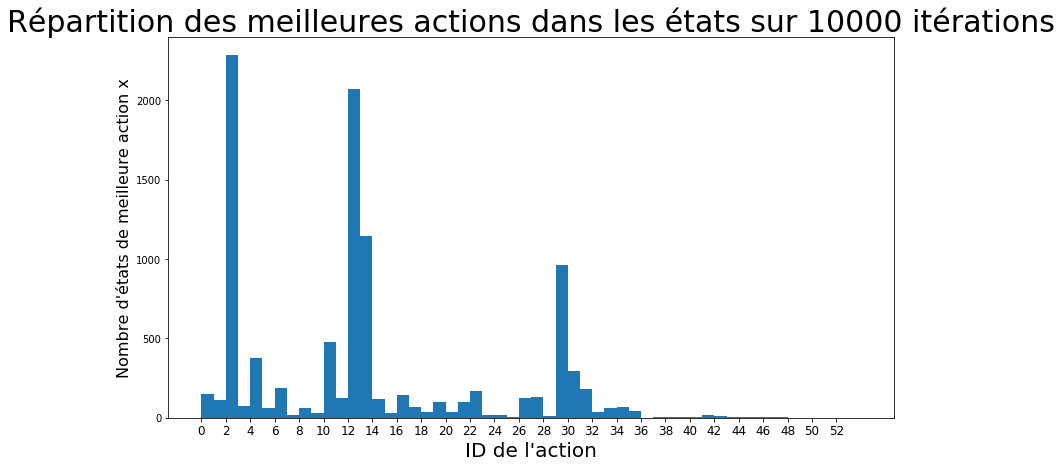

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

intToAct = dict()
for i in range(len(actionList)):
    intToAct[i] = actionList[i]

actToInt = dict()
for i in range(len(actionList)):
    actToInt[actionList[i]] = i

def codeAction(action):
    return actToInt[action]

def decodeAction(key):
    return intToAct[key]

histArray = []
with open("saved_actions.csv",'r') as doneActions:
    lineN = 0
    while lineN < 10001:
        action = doneActions.readline()
        action = action.replace(",","")
        action = action.replace("\n","")
        histArray.append(codeAction(action))
        lineN += 1

plt.figure(figsize=(13,7))
plt.xticks(np.arange(0,54,2),fontsize=12)
fig = plt.hist(histArray,np.arange(55))
plt.xlabel("ID de l'action",fontsize=20)
plt.ylabel("Nombre d'états de meilleure action x",fontsize=16)
plt.title("Répartition des meilleures actions dans les états sur 10000 itérations",fontsize=30)

<h2> Pour décoder l'action

In [14]:
print(decodeAction(#Numero))

0000000000000000000000000000000110000000000010000010000000000000000000000000
